# LiteCoin Price Prediction 2021

## 1. Data Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, classification_report,accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional, Input, GRU
from keras.models import Sequential,Model

In [2]:
df = pd.read_csv('data/coin_Litecoin.csv')

#spliting 'Date' column to 'date' and 'time'
df['Date'] = pd.to_datetime(df['Date'])
df['date'] = df['Date'].dt.date
df['time'] = df['Date'].dt.time

#drop non-relevant columns
df.drop(['SNo','Name','Symbol','Date','time'], axis=1, inplace=True,errors='ignore')
#set date as new index
df.set_index('date',inplace=True)

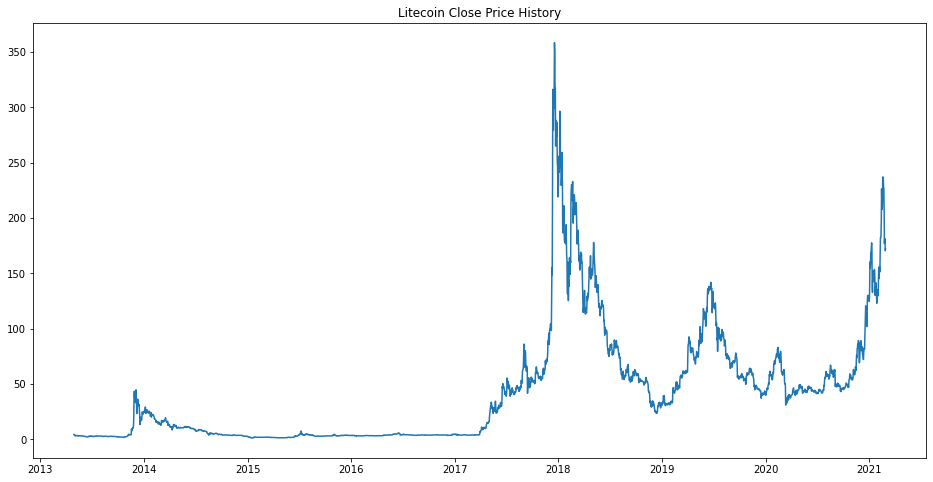

In [3]:
plt.figure(figsize=(16,8))
plt.title('Litecoin Close Price History')
plt.plot(df['Close'])

# Using 1 input for LSTM model

## 2.Data Preprocessing

In [4]:
df = df.loc[pd.to_datetime(df.index) > pd.to_datetime('2017-06-01'),:]

In [5]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.95)]
test_df = df[int(n*0.95):]

num_features = df.shape[1]

In [6]:
#Create a new dataframe with only close column
#data = df.filter(['Close'])
#convert to a numpy array
#dataset = data.values

#get the number of rows to train the model on
#train_idx = math.ceil(len(dataset) * .8)

#train_idx

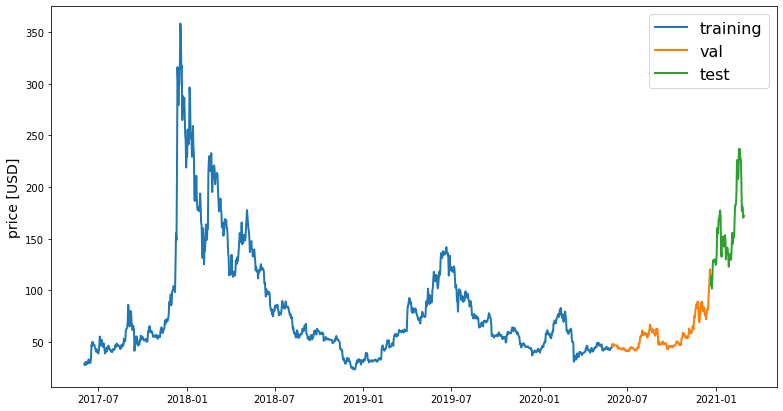

In [7]:
def line_plot2(line1, line2,label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

def line_plot3(line1, line2,line3, label1=None, label2=None,label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)


line_plot3(line1 = train_df.filter(['Close']), 
          line2 = val_df.filter(['Close']),
          line3 = test_df.filter(['Close']), label1='training',label2='val',label3= 'test', title='')

### 2.1 Data Normalization

In [38]:
def scale_func(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_data = pd.DataFrame(scaled_data,index=df.index, columns=df.columns)
    return scaled_data, scaler

scaled_train_df, scaler  = scale_func(train_df) 
scaled_val_df = pd.DataFrame(scaler.transform(val_df),index=val_df.index,columns=val_df.columns)
scaled_test_df = pd.DataFrame(scaler.transform(test_df),index=test_df.index,columns=test_df.columns)

In [39]:
#create the training data set
def generate_input(df, window, target):
    #create the scaled training data set
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(window, len(df)):
        x_train.append(df.iloc[i-window:i, :][target])
        y_train.append(df.iloc[i,:,][target])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train

In [40]:
x_train, y_train = generate_input(scaled_train_df,15, "Close")
#convert x_train and y_train to numpy arrays
x_val, y_val = generate_input(scaled_val_df,15, "Close")
x_test, y_test = generate_input(scaled_test_df,15, "Close")

print("Training set:",x_train.shape)
print("Validation set:",x_val.shape)
print("Test set:",x_test.shape)

Training set: (1078, 15, 1)
Validation set: (190, 15, 1)
Test set: (54, 15, 1)


In [36]:
def model_base_build(input_shape):
    #build the lstm model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape = input_shape))
    model.add(LSTM(50, return_sequences=False, dropout=0.3, recurrent_dropout=0.4))
    model.add(Dense(1))
    model.add(Activation('linear'))
    #compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_class_build(input_shape):
    #build the lstm model
    model = Sequential()
    #### Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    #### Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    #### Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    #### Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    #### Adding the output layer
    model.add(Dense(units = 1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_bidirectional(input_shape):
    #build the lstm model
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape = input_shape)))
    model.add(Bidirectional(LSTM(50, return_sequences=False, dropout=0.2, recurrent_dropout=0.4)))
    model.add(Dense(1))
    model.add(Activation('linear'))
    #compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_GRU_build(input_shape):
    model = Sequential()
    # Input layer
    model.add(GRU(100, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.4)) 
    # Hidden layer
    model.add(GRU(100)) 
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def accuracy_forecast(target_val ,prediction_val):   
    bi_targ = np.sign(target_val.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))[1:].values
    bi_pred = np.sign(prediction_val.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))[1:].values
    return accuracy_score(bi_targ,bi_pred)

In [41]:
model = model_base_build(input_shape= (x_train.shape[1],x_train.shape[2]))

In [42]:
#train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=8, epochs=30)

Epoch 1/30
135/135 [==============================] - 6s 14ms/step - loss: 0.0115 - val_loss: 5.3137e-04
Epoch 2/30
135/135 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 4.5938e-04
Epoch 3/30
135/135 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 4.0389e-04
Epoch 4/30
135/135 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 3.5828e-04
Epoch 5/30
135/135 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 2.6302e-04
Epoch 6/30
135/135 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 3.6430e-04
Epoch 7/30
135/135 [==============================] - 1s 10ms/step - loss: 8.7915e-04 - val_loss: 2.4031e-04
Epoch 8/30
135/135 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 2.5444e-04
Epoch 9/30
135/135 [==============================] - 1s 10ms/step - loss: 9.8187e-04 - val_loss: 2.8577e-04
Epoch 10/30
135/135 [==========================

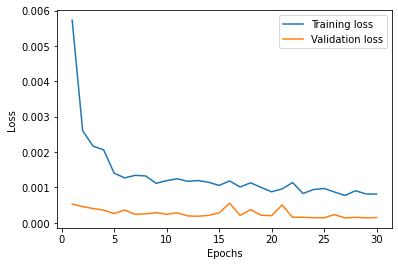

In [43]:
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'],label="Training loss")
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'],label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
target_scaler = MinMaxScaler()
target_scaler.fit(train_df[['Close']])
#Get the models predicted price values
predictions = model.predict(x_val)
predictions = target_scaler.inverse_transform(predictions)
valid=val_df[15:][['Close']].copy()
valid['Predictions'] = predictions
#get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Close']) ** 2)

print("RMSE:",rmse)
print("MAE", mean_absolute_error(valid['Close'], valid['Predictions']))
print("Accuracy:",accuracy_forecast(valid['Close'], valid['Predictions']))

RMSE: 1.7558883375529466
MAE 3.1921975777901954
Accuracy: 0.4444444444444444


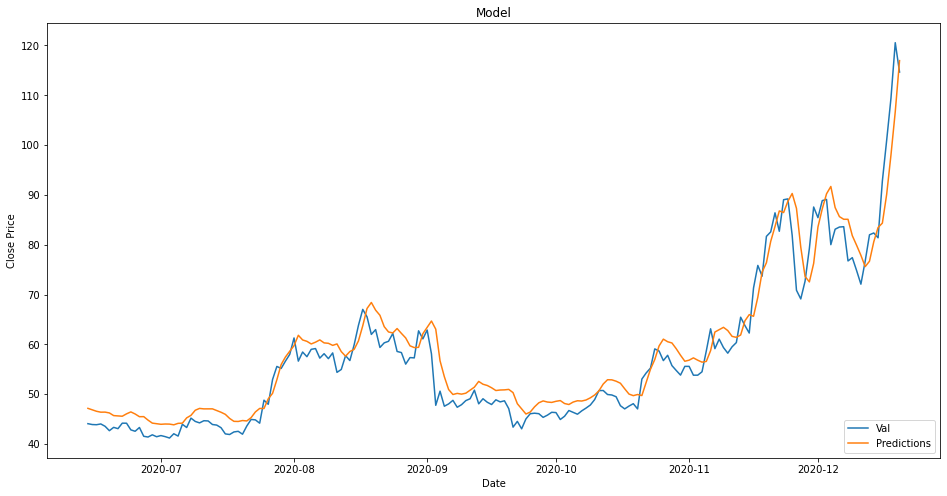

In [45]:
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val','Predictions'], loc='lower right')
plt.show()

In [47]:
LINK_quote = web.DataReader('LTC-USD', data_source='yahoo', start='2017-09-21', end='2021-03-10')
#create a new dataframe
new_df = LINK_quote.filter(['Close'])
#Get the last 60 day closing price
last_60_days = new_df[-15:].values
#scale the data
last_60_days_scale = scaler.transform(last_60_days)
#create an empty list
X_test = []
X_test.append(last_60_days_scale)
#convert the x_test to np.array
X_test = np.array(X_test)
#reshape
X_test = np.reshape(X_test, ((X_test.shape[0], X_test.shape[1], 1)))
#get predicted price
pred_price = model.predict(X_test)
#undo scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

ValueError: non-broadcastable output operand with shape (15,1) doesn't match the broadcast shape (15,6)

In [106]:
LINK_quote2 = web.DataReader('LTC-USD', data_source='yahoo', start='2021-03-11', end='2021-03-11')
print(LINK_quote2)

                  High         Low        Open       Close      Volume  \
Date                                                                     
2021-03-11  203.167831  191.536835  200.449753  201.250336  4823154653   
2021-03-12  223.614975  198.953842  201.273666  220.829407  8079722567   

             Adj Close  
Date                    
2021-03-11  201.250336  
2021-03-12  220.829407  


## Multiple input with normal features

In [116]:
df

,High,Low,Open,Close,Volume,Marketcap
date,,,,,,
2017-09-21,0.207892,0.155292,0.189132,0.169680,2.126270e+06,5.938800e+07
2017-09-22,0.181675,0.139869,0.169826,0.150503,1.423220e+06,5.267605e+07
2017-09-23,0.157440,0.126297,0.149562,0.131129,1.186670e+06,4.589515e+07
2017-09-24,0.190250,0.130275,0.131110,0.170278,1.025740e+06,5.959730e+07
2017-09-25,0.182637,0.158580,0.170636,0.182198,1.021370e+06,6.376930e+07
...,...,...,...,...,...,...
2021-02-23,31.549831,21.198072,31.522873,25.800343,5.101236e+09,1.053969e+10
2021-02-24,29.178788,24.645512,25.827651,28.086719,3.087990e+09,1.147369e+10
2021-02-25,28.556830,24.595960,28.073373,24.668047,2.016769e+09,1.007713e+10


In [24]:
scaled_train_df, scaler  = scale_func(train_df) 
scaled_val_df = pd.DataFrame(scaler.transform(val_df), index=val_df.index,columns=val_df.columns)
scaled_test_df = pd.DataFrame(scaler.transform(test_df), index=test_df.index,columns=test_df.columns)

In [25]:
def multiinput_generator(df, target, window):
    feature_cols = df.columns  
    x_train = []
    y_train = []
    for i in range(window, len(df)):
        x_train.append(df.iloc[i-window:i,:])
        y_train.append(df.iloc[i,:][target])
    #convert x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    return x_train,y_train

x_train, y_train = multiinput_generator(scaled_train_df, "Close", 5)
x_val, y_val = multiinput_generator(scaled_val_df, "Close", 5)
x_test, y_test = multiinput_generator(scaled_test_df, "Close", 5)
#coin_history, x_cols = create_history_frames(coin_dataframes)

In [26]:
#build the lstm model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(LSTM(50, return_sequences=False, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1))
model.add(Activation('linear'))
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
#train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=True, batch_size=16, epochs=100)

Epoch 1/100
68/68 [==============================] - 3s 11ms/step - loss: 0.0162 - val_loss: 6.1670e-04
Epoch 2/100
68/68 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 3.6434e-04
Epoch 3/100
68/68 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 2.8671e-04
Epoch 4/100
68/68 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 2.8493e-04
Epoch 5/100
68/68 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 2.6492e-04
Epoch 6/100
68/68 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 2.9914e-04
Epoch 7/100
68/68 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 2.7448e-04
Epoch 8/100
68/68 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 2.1313e-04
Epoch 9/100
68/68 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 7.1787e-04
Epoch 10/100
68/68 [==============================] - 0s 3ms/step - loss

68/68 [==============================] - 0s 3ms/step - loss: 6.6227e-04 - val_loss: 2.3998e-04
Epoch 78/100
68/68 [==============================] - 0s 3ms/step - loss: 6.9473e-04 - val_loss: 1.0919e-04
Epoch 79/100
68/68 [==============================] - 0s 3ms/step - loss: 6.8525e-04 - val_loss: 1.3025e-04
Epoch 80/100
68/68 [==============================] - 0s 3ms/step - loss: 5.7502e-04 - val_loss: 1.5736e-04
Epoch 81/100
68/68 [==============================] - 0s 3ms/step - loss: 8.2563e-04 - val_loss: 9.0300e-05
Epoch 82/100
68/68 [==============================] - 0s 3ms/step - loss: 4.1721e-04 - val_loss: 1.1604e-04
Epoch 83/100
68/68 [==============================] - 0s 3ms/step - loss: 8.4142e-04 - val_loss: 1.0519e-04
Epoch 84/100
68/68 [==============================] - 0s 3ms/step - loss: 4.6100e-04 - val_loss: 1.0386e-04
Epoch 85/100
68/68 [==============================] - 0s 3ms/step - loss: 8.2787e-04 - val_loss: 9.4269e-05
Epoch 86/100
68/68 [=====================

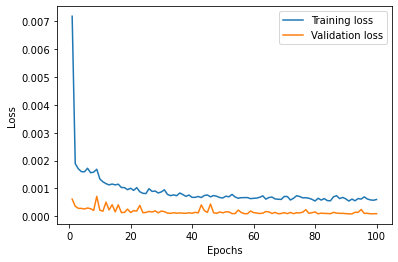

In [28]:
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'],label="Training loss")
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'],label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
target_scaler = MinMaxScaler()
target_scaler.fit(train_df[['Close']])
#Get the models predicted price values
predictions = model.predict(x_val)
predictions = target_scaler.inverse_transform(predictions)

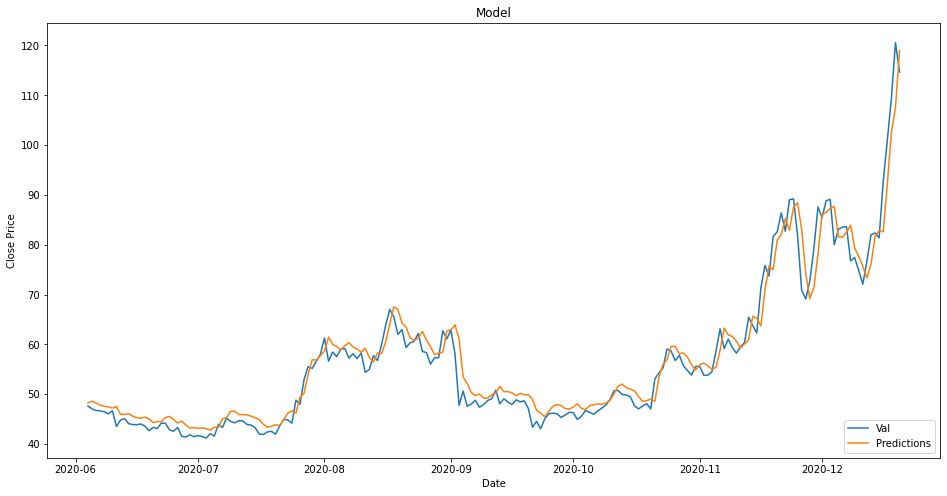

In [30]:
#plot the data
valid = val_df[['Close']][5:].copy()
valid['Predictions'] = predictions
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val','Predictions'], loc='lower right')
plt.show()

In [31]:
mean_absolute_error(valid['Close'], valid['Predictions'])

2.388547839669816

### Test data

In [32]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = target_scaler.inverse_transform(predictions)

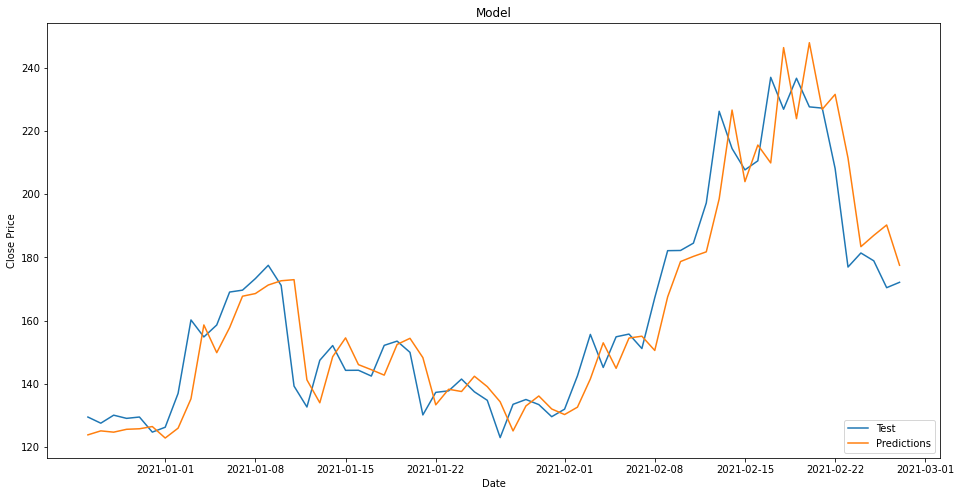

In [33]:
#plot the data
valid = test_df[['Close']][5:].copy()
valid['Predictions'] = predictions
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Test','Predictions'], loc='lower right')
plt.show()

In [34]:
mean_absolute_error(valid['Close'], valid['Predictions'])

8.999977738949585

# Bidirectional

In [106]:
#build the lstm model
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],x_train.shape[2]))))
model.add(Bidirectional(LSTM(50, return_sequences=False, dropout=0.2, recurrent_dropout=0.4)))
model.add(Dense(1))
model.add(Activation('linear'))
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [107]:
#train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=False,batch_size=16, epochs=100)

Epoch 1/100
60/60 [==============================] - 34s 72ms/step - loss: 0.5155 - val_loss: 0.0671
Epoch 2/100
60/60 [==============================] - 1s 13ms/step - loss: 0.1776 - val_loss: 0.0054
Epoch 3/100
60/60 [==============================] - 1s 15ms/step - loss: 0.2099 - val_loss: 0.0641
Epoch 4/100
60/60 [==============================] - 1s 13ms/step - loss: 0.1193 - val_loss: 0.0052
Epoch 5/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0681 - val_loss: 0.0064
Epoch 6/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0599 - val_loss: 0.0088
Epoch 7/100
60/60 [==============================] - 1s 15ms/step - loss: 0.0811 - val_loss: 0.0121
Epoch 8/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0656 - val_loss: 0.0077
Epoch 9/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0563 - val_loss: 0.0083
Epoch 10/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0500 - val_loss: 0.005

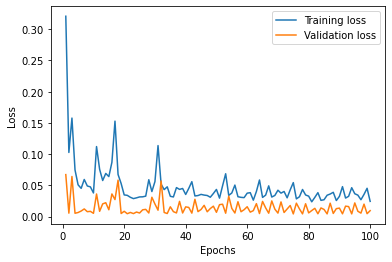

In [108]:
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'],label="Training loss")
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'],label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [110]:
target_scaler = StandardScaler()
target_scaler.fit(train_df[['Close']])
#Get the models predicted price values
predictions = model.predict(x_val)
predictions = target_scaler.inverse_transform(predictions)

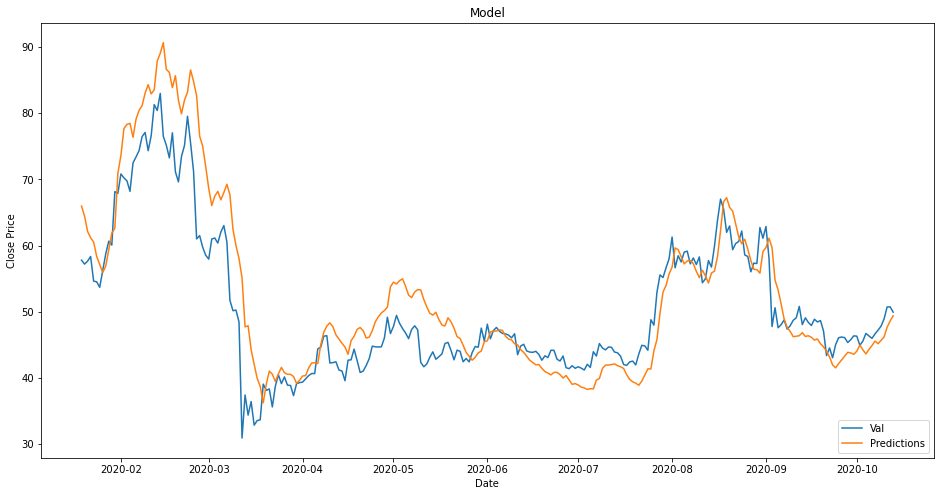

In [111]:
#plot the data
valid = val_df[['Close']][5:].copy()
valid['Predictions'] = predictions
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val','Predictions'], loc='lower right')
plt.show()

In [112]:
mean_absolute_error(valid['Close'], valid['Predictions'])

4.050404185172386

### Test data

In [113]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = target_scaler.inverse_transform(predictions)

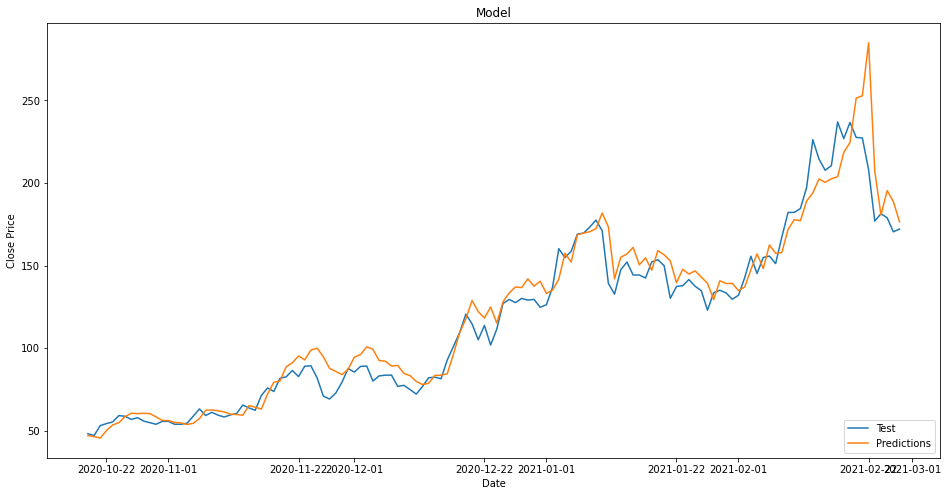

In [114]:
#plot the data
valid = test_df[['Close']][5:].copy()
valid['Predictions'] = predictions
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Test','Predictions'], loc='lower right')
plt.show()

In [115]:
mean_absolute_error(valid['Close'], valid['Predictions'])

8.477366795583865